In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
# !pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels as sm
import statsmodels.tsa.seasonal
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [2]:
df = pd.read_csv('/content/Supermart Grocery Sales - Retail Analytics Dataset.csv')


In [3]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [4]:
df['Category'].unique()

array(['Oil & Masala', 'Beverages', 'Food Grains', 'Fruits & Veggies',
       'Bakery', 'Snacks', 'Eggs, Meat & Fish'], dtype=object)

In [5]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [6]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal.seasonal_decompose(df, model='additive', extrapolate_trend=12)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()
    
    return trend, seasonal, residual

In [7]:
cat = ['Oil & Masala', 'Beverages', 'Food Grains', 'Fruits & Veggies',
       'Bakery', 'Snacks', 'Eggs, Meat & Fish']

In [8]:
table1 = {'Oil & Masala' : [], 'Beverages' : [], 'Food Grains' : [], 'Fruits & Veggies' : [],
       'Bakery' : [], 'Snacks' : [], 'Eggs, Meat & Fish' : []}

In [9]:
def fun(i):
  print('_______________________________________________________________________')
  print(i,'\n')
  bvrg = df[df['Category'] == i]
  # print(type(bvrg))
  bvrg = bvrg.sort_values(by=['Order Date'])
  bvrg = bvrg.groupby([bvrg['Order Date'].dt.year, bvrg['Order Date'].dt.month]).sum(['Sales', 'Profit', 'Discount'])
  bvrg['Date'] = pd.date_range(start='1-1-2015', end='1-1-2019', freq='M')
  bvrg1 = bvrg[['Sales', 'Date']]
  bvrg1 = bvrg1.set_index('Date')

  plt.figure(figsize=(15,7))
  plt.plot(bvrg1['Sales'], label='Original')
  plt.plot(bvrg1['Sales'].rolling(window=12).mean(), color='red', label='Rolling mean')
  plt.plot(bvrg1['Sales'].rolling(window=12).std(), color='green', label='Rolling std')
  plt.xlabel('Date', fontsize=12)
  plt.ylabel('Passengers', fontsize=12)
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')

  ADF_test(bvrg1)

  trend, seasonal, residual = seasonal_decompose(bvrg1)

  train_data = bvrg1['Sales'][:int(len(bvrg)*0.8)]
  test_data = bvrg1['Sales'][int(len(bvrg)*0.8):]

  train_data = bvrg1['Sales'][:-12]
  test_data = bvrg1['Sales'][-12:]

  train_data = train_data.to_frame(name='Sales')
  test_data = test_data.to_frame(name='Sales')

  # Original Series
  fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 10))
  ax1.plot(train_data)
  ax1.set_title('Original Series')
  ax1.axes.xaxis.set_visible(False)
  # 1st Differencing
  ax2.plot(train_data.diff())
  ax2.set_title('1st Order Differencing')
  ax2.axes.xaxis.set_visible(False)
  # 2nd Differencing
  ax3.plot(train_data.diff().diff())
  ax3.set_title('2nd Order Differencing')
  plt.show()

  _ = plot_pacf(train_data.dropna(), method='ywm')

  _ = plot_acf(train_data.dropna())

  ARIMA_model = pm.auto_arima(train_data, m=12)
  ARIMA_model.summary()

  # 12, 0, 0 good
  model = ARIMA(train_data, order=(12, 0, 0))
  model_fit = model.fit()
  model_fit.summary()

  test_predictions = model_fit.forecast(len(test_data))

  rmse = np.sqrt(mean_squared_error(test_data,test_predictions))
  mae = mean_absolute_error(test_data,test_predictions)
  r2 = r2_score(test_data['Sales'], test_predictions)
  mape = mean_absolute_percentage_error(test_data['Sales'], test_predictions)

  print(f'Mean Absolute Error = {mae}')
  print(f'Root Mean Squared Error = {rmse}')
  print(f'r2 score = {r2}')
  print(f'Mean absolute percentage error = {mape}')

  table1[str(i)].append(mae)
  table1[str(i)].append(rmse)
  table1[str(i)].append(r2)
  table1[str(i)].append(mape)

_______________________________________________________________________
Oil & Masala 

Results of Dickey-Fuller Test:
Test Statistic                 -3.988121
p-value                         0.001474
Lags Used                       0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


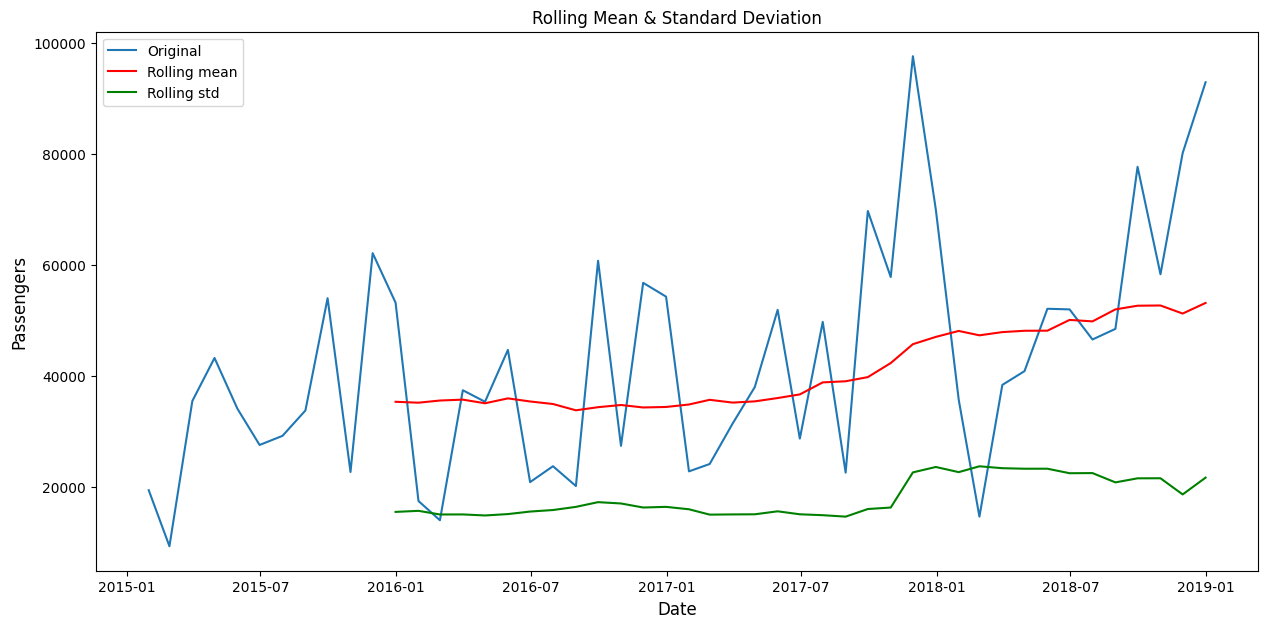

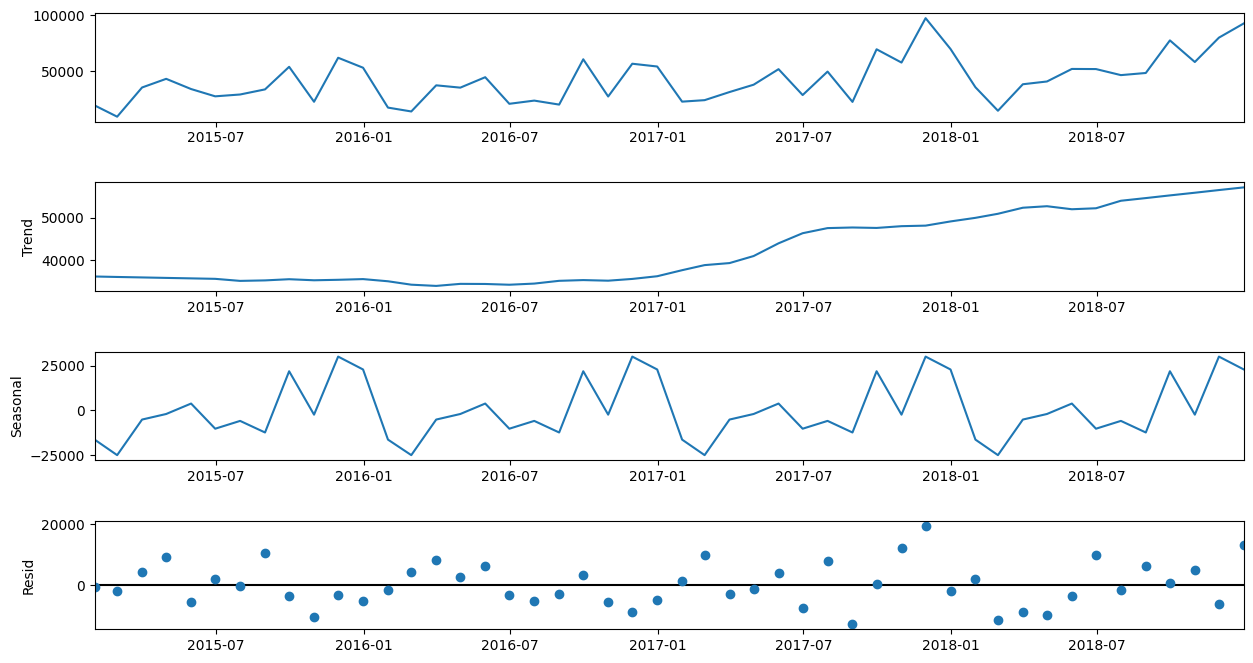

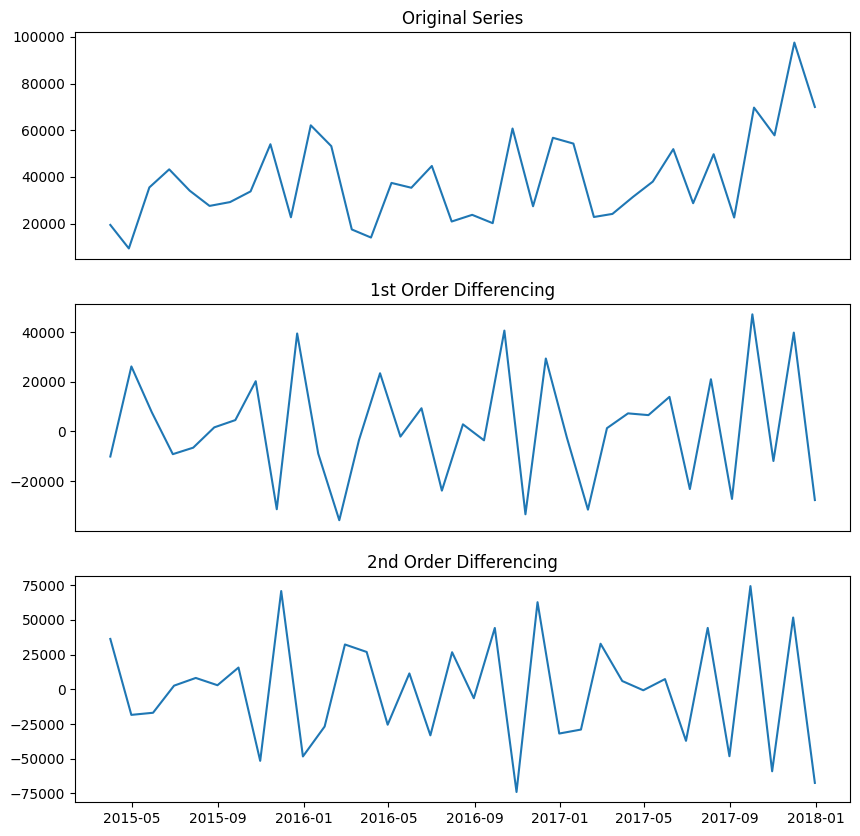

Mean Absolute Error = 17009.12128651748
Root Mean Squared Error = 21242.501162298966
r2 score = -0.049192023020237174
Mean absolute percentage error = 0.400255839044764
_______________________________________________________________________
Beverages 

Results of Dickey-Fuller Test:
Test Statistic                 -3.554054
p-value                         0.006703
Lags Used                       0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


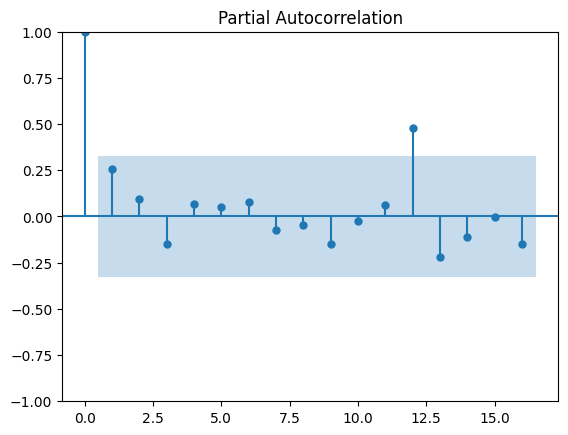

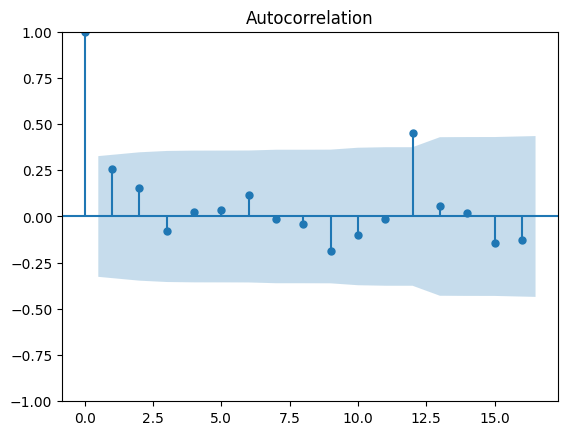

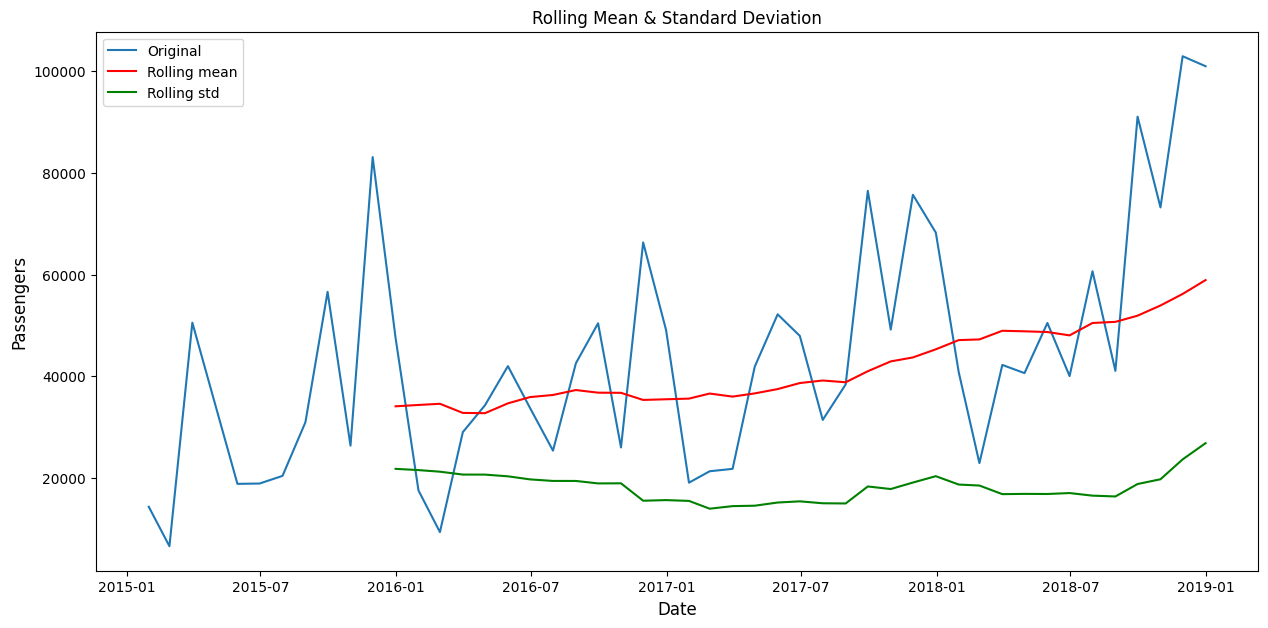

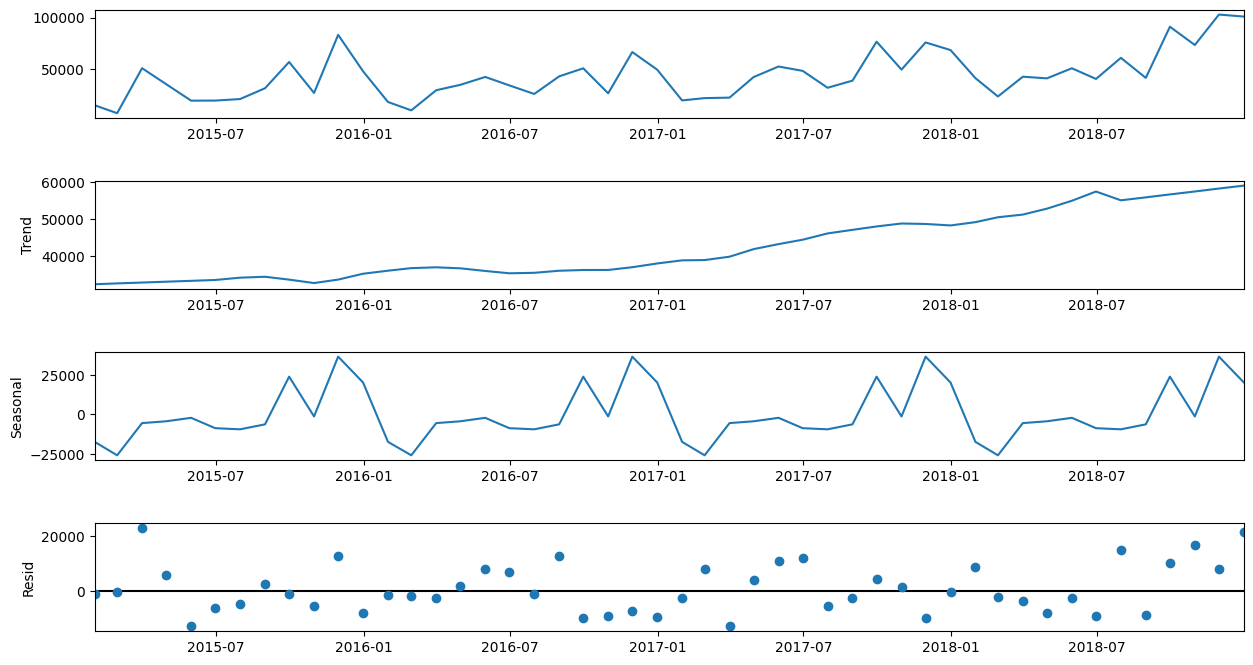

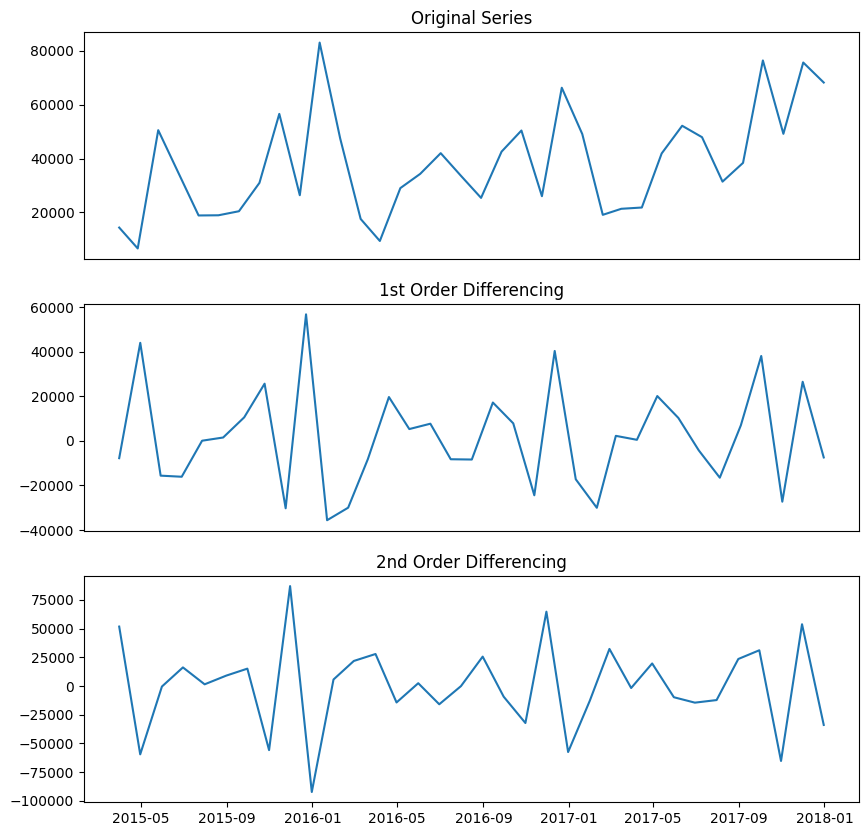

Mean Absolute Error = 18423.78620726474
Root Mean Squared Error = 21081.351703877746
r2 score = 0.3271679712660671
Mean absolute percentage error = 0.3073939269568782
_______________________________________________________________________
Food Grains 

Results of Dickey-Fuller Test:
Test Statistic                 -3.775124
p-value                         0.003172
Lags Used                       0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


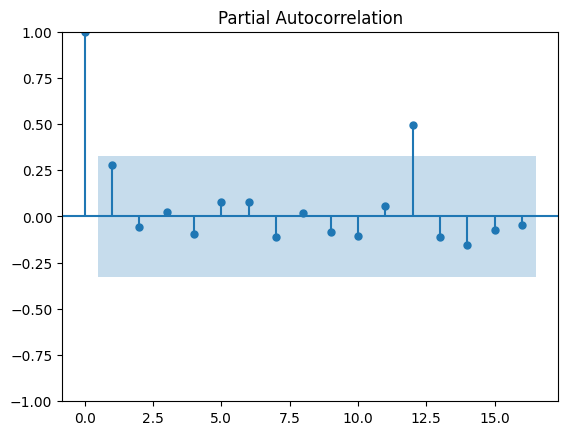

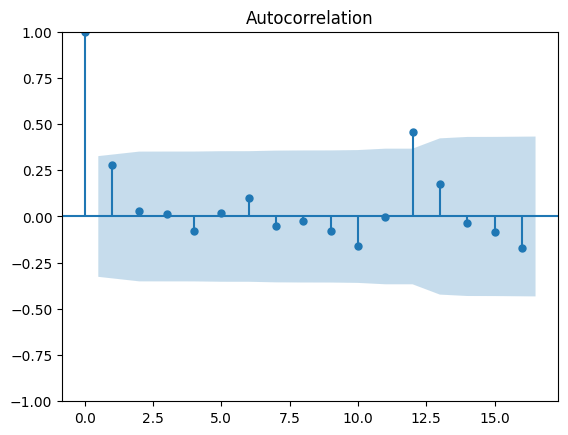

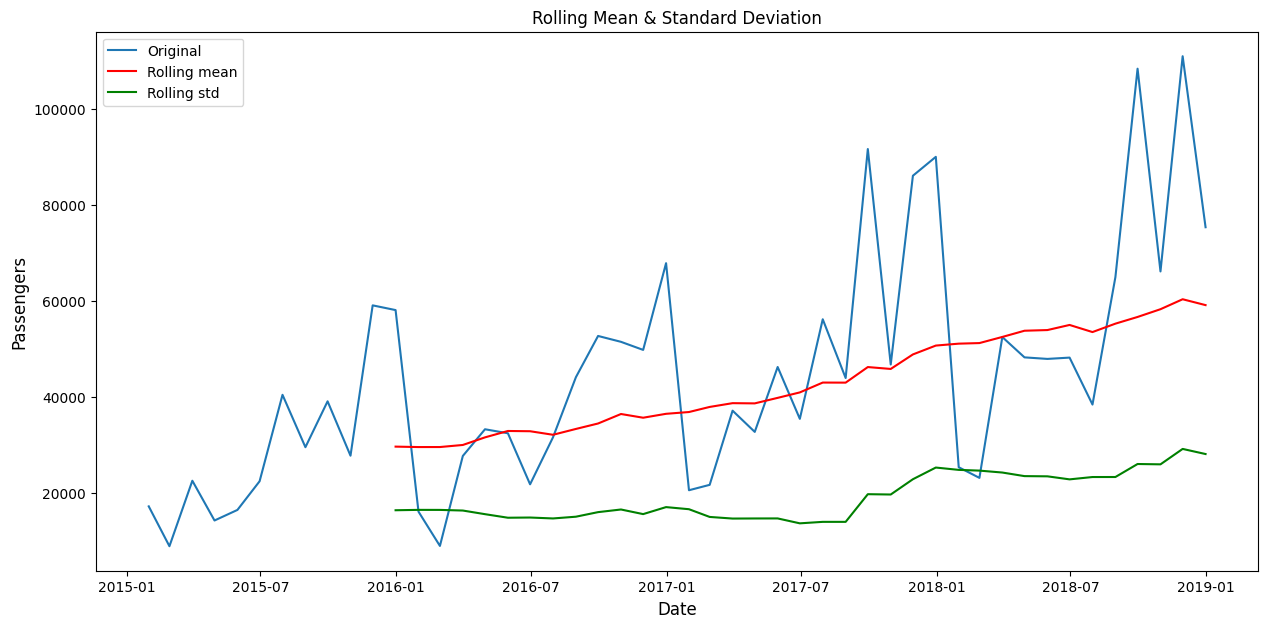

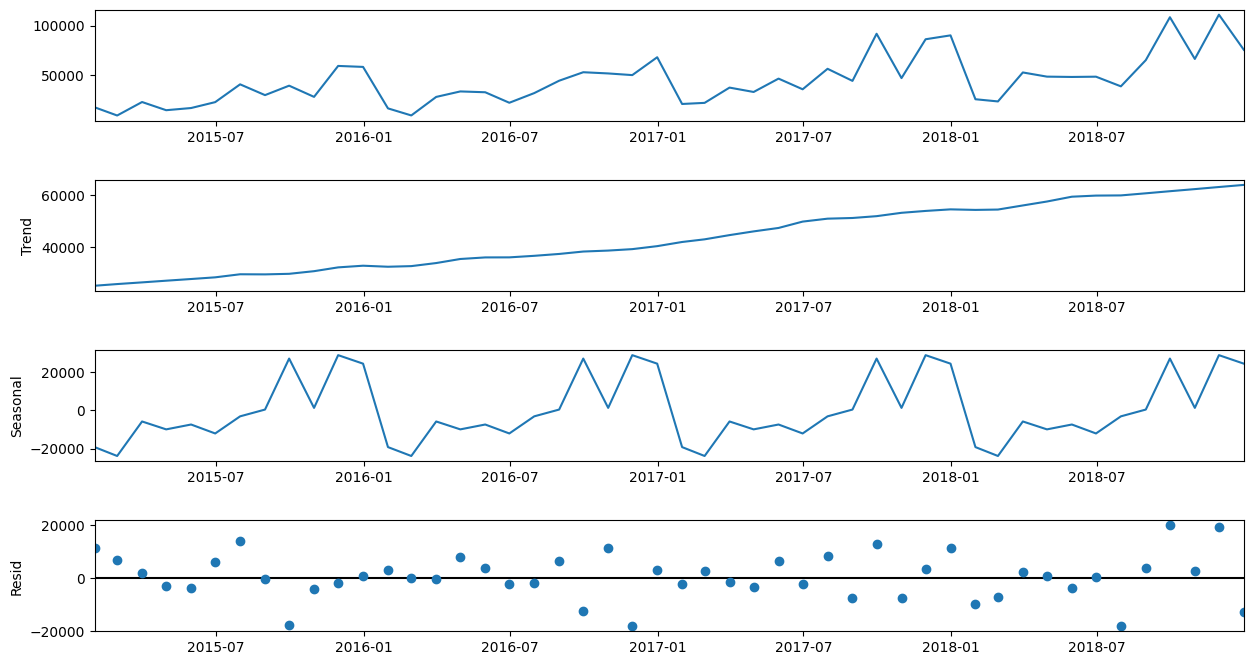

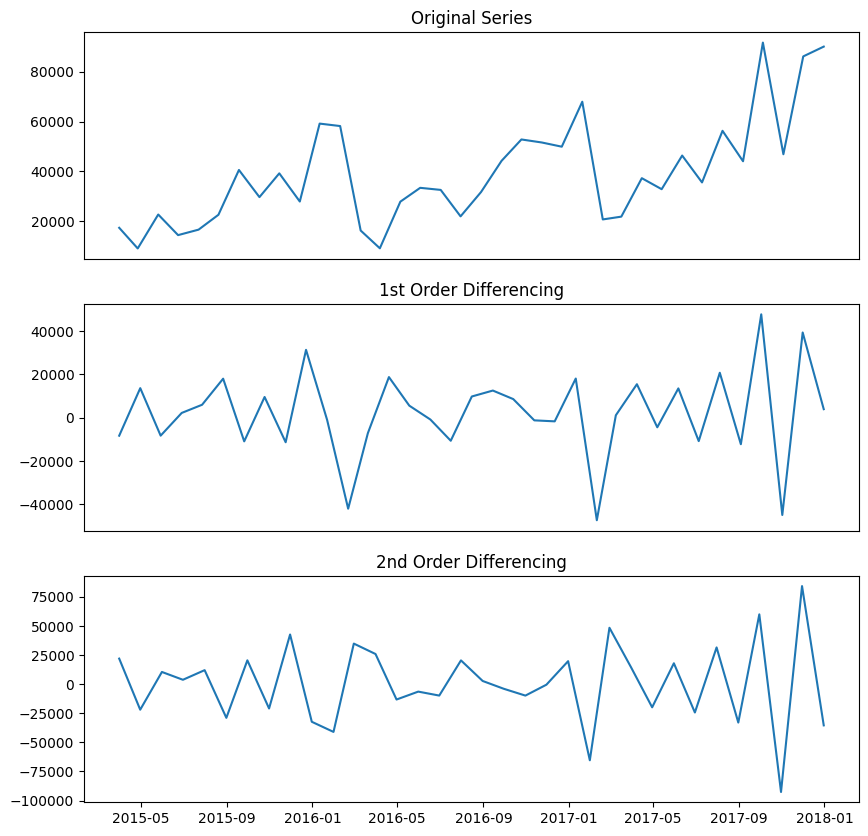

Mean Absolute Error = 18727.270960022124
Root Mean Squared Error = 22628.11575732767
r2 score = 0.29660754598324557
Mean absolute percentage error = 0.3818245862178968
_______________________________________________________________________
Fruits & Veggies 

Results of Dickey-Fuller Test:
Test Statistic                 -3.716338
p-value                         0.003889
Lags Used                       0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


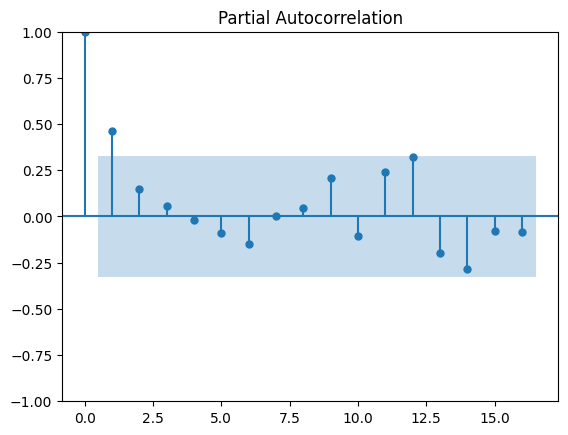

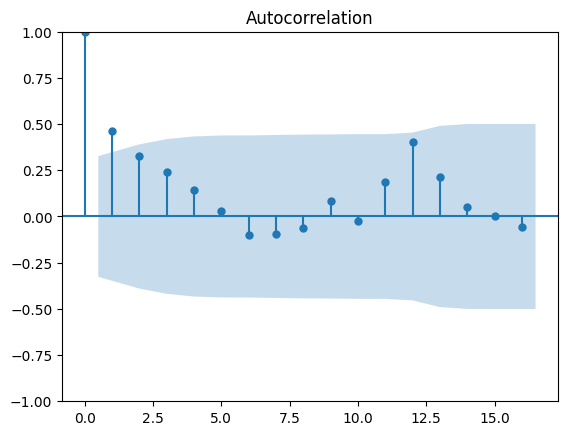

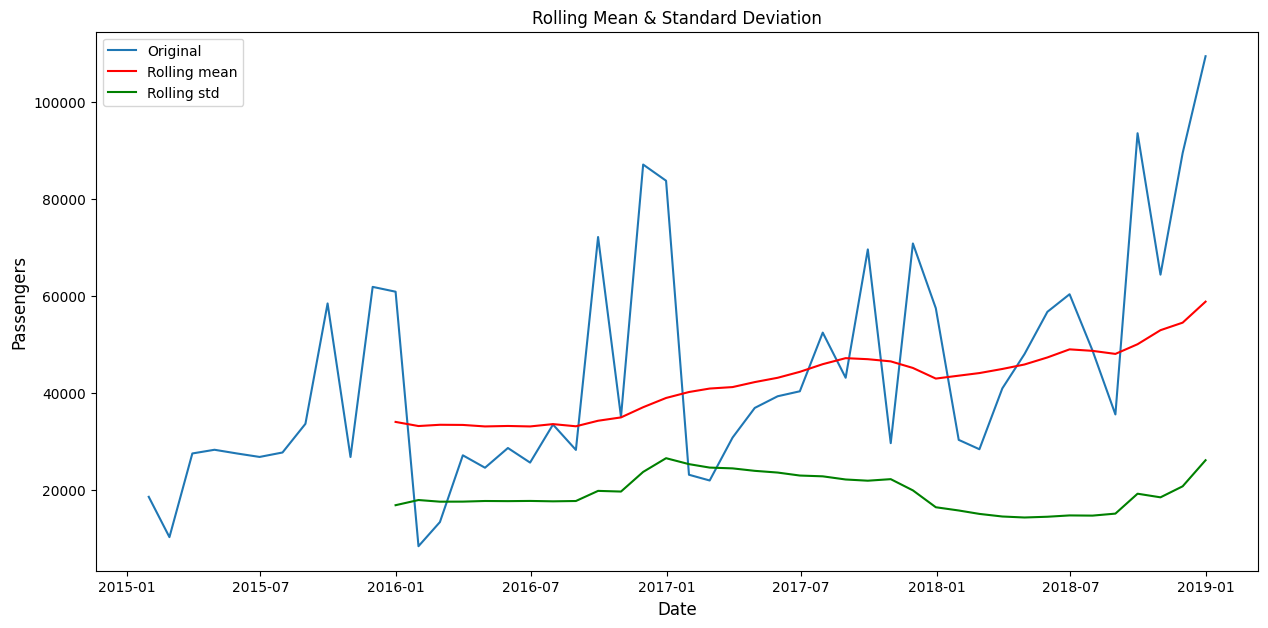

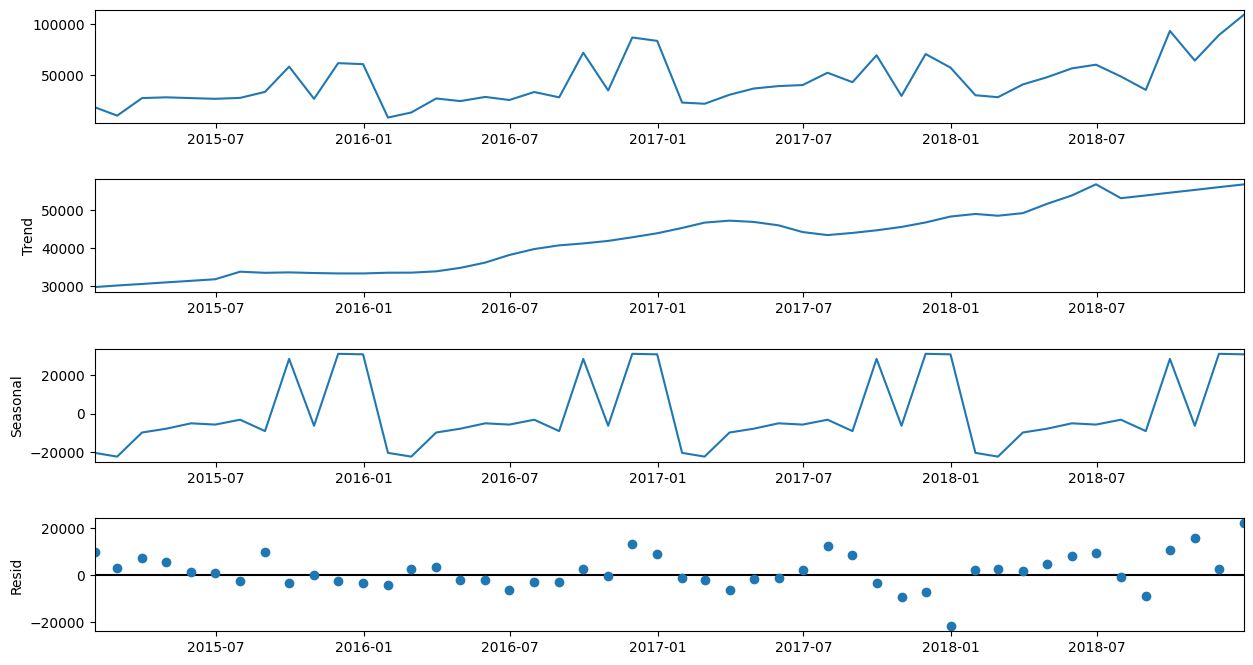

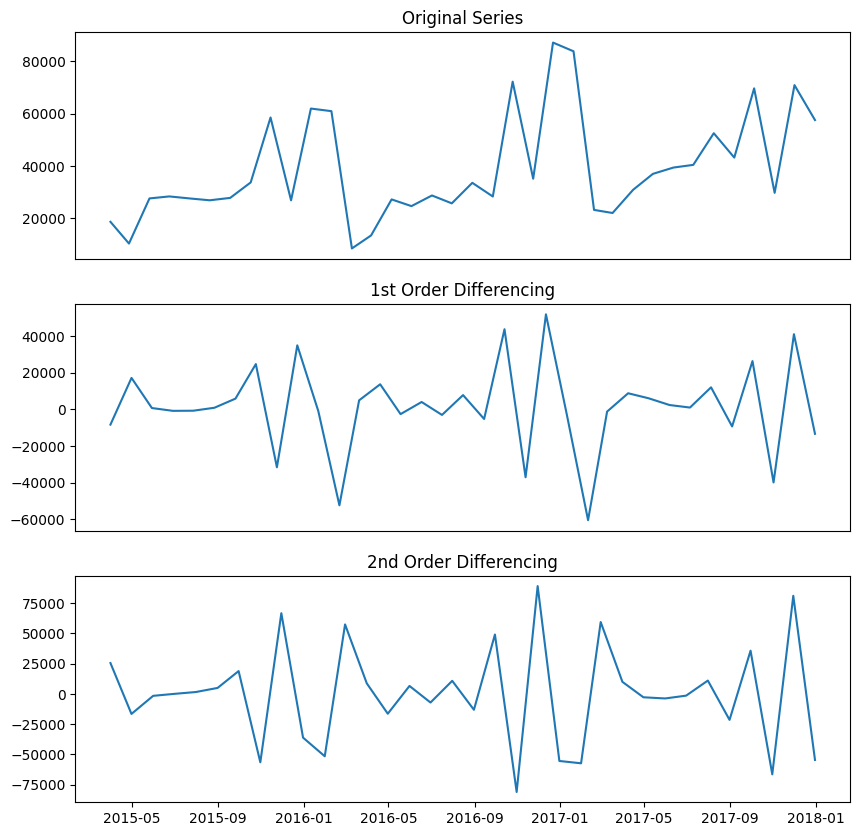

Mean Absolute Error = 18923.483735336686
Root Mean Squared Error = 24471.261654250422
r2 score = 0.048740130455318664
Mean absolute percentage error = 0.27612193256296086
_______________________________________________________________________
Bakery 

Results of Dickey-Fuller Test:
Test Statistic                 -4.025953
p-value                         0.001281
Lags Used                       0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


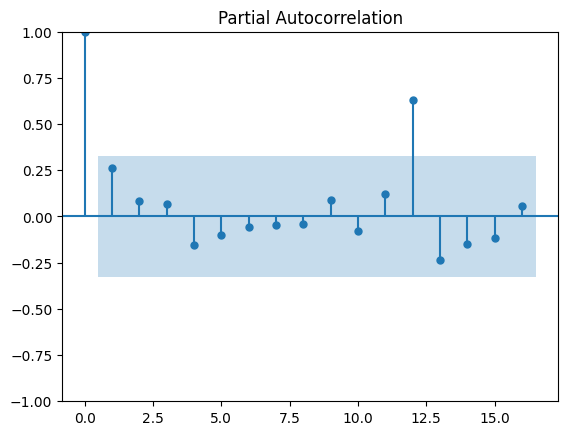

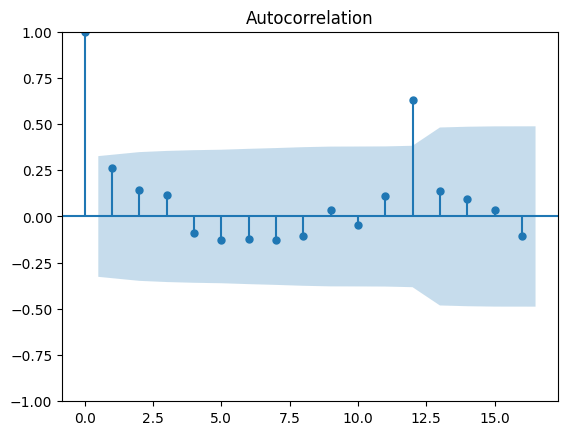

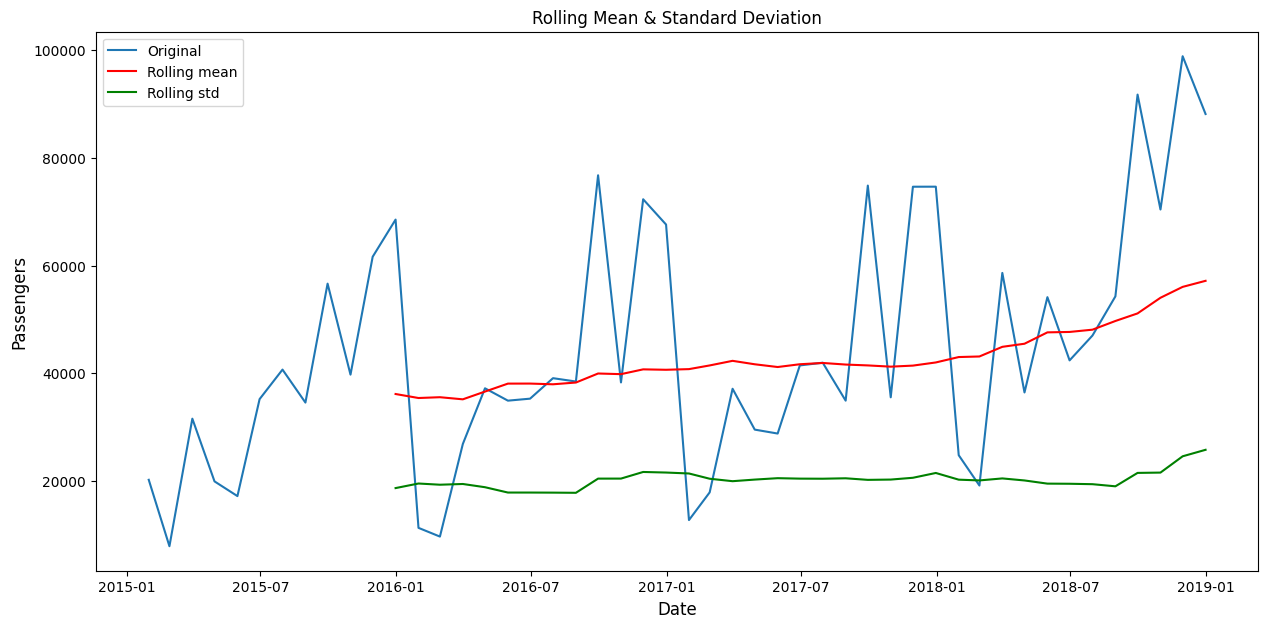

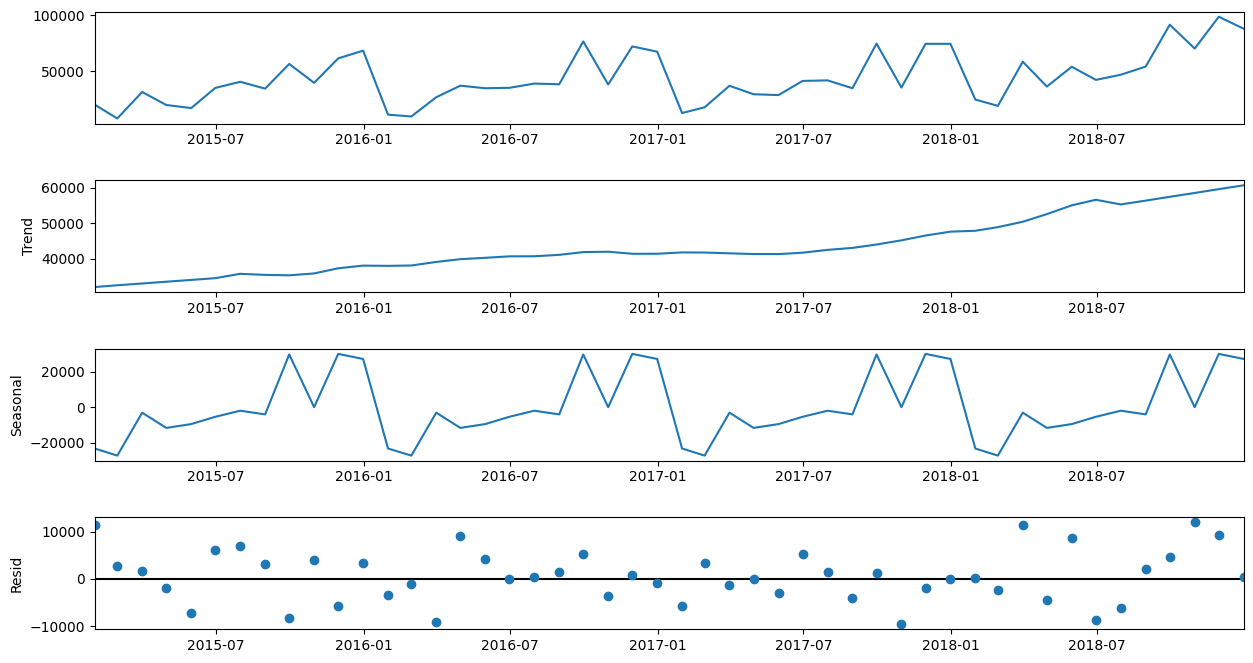

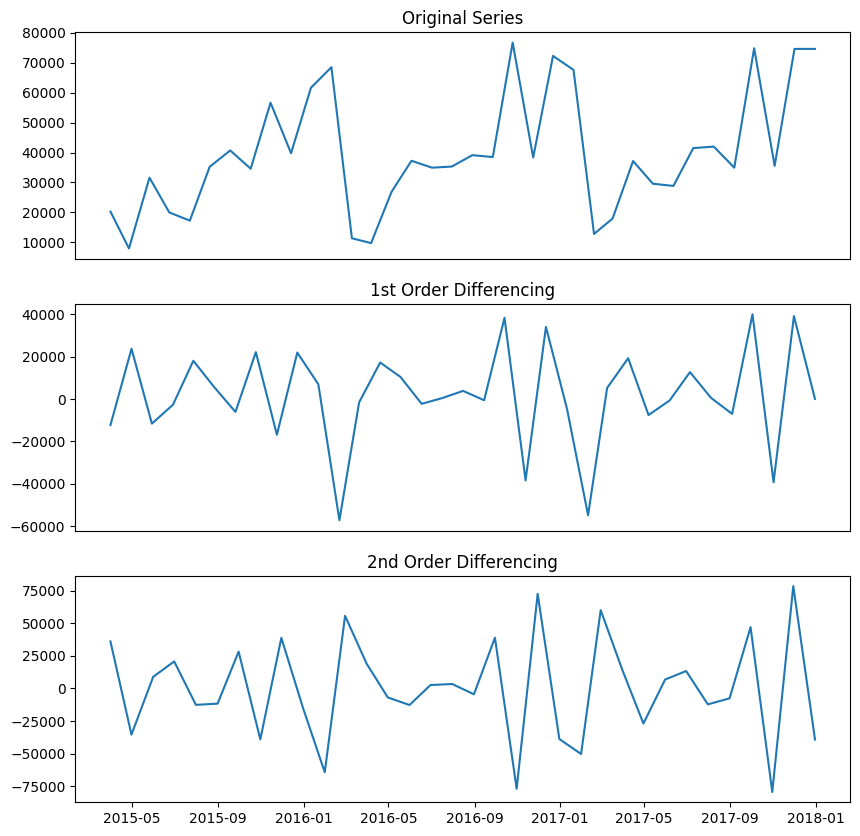

Mean Absolute Error = 16092.301001268752
Root Mean Squared Error = 18839.276026226667
r2 score = 0.4187581988554443
Mean absolute percentage error = 0.2720118542799736
_______________________________________________________________________
Snacks 

Results of Dickey-Fuller Test:
Test Statistic                 -1.468981
p-value                         0.548797
Lags Used                       2.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


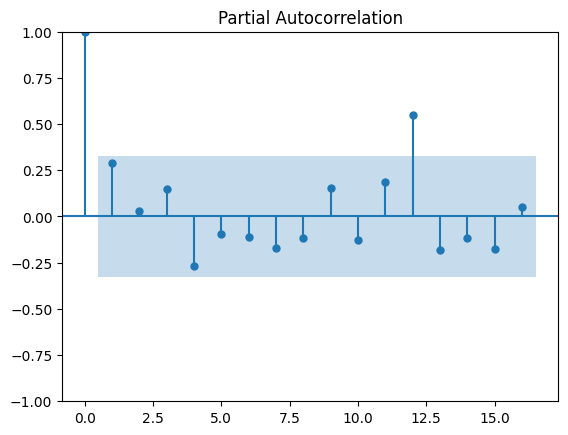

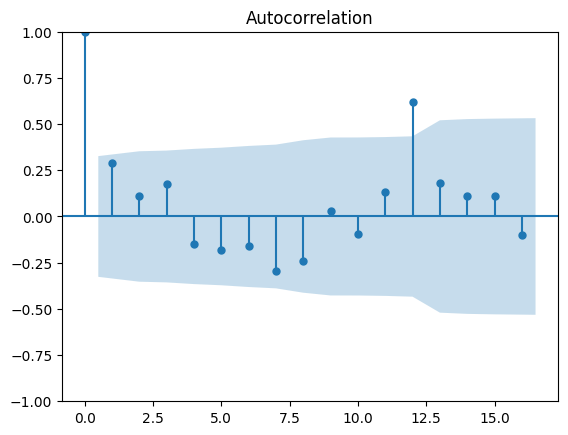

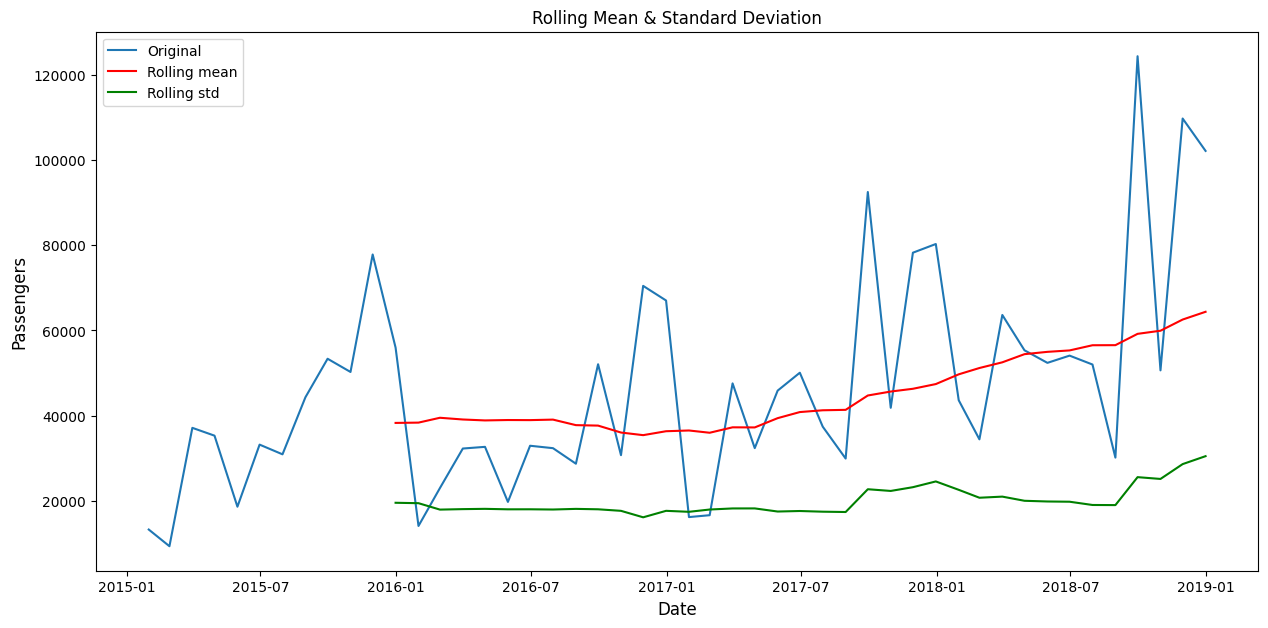

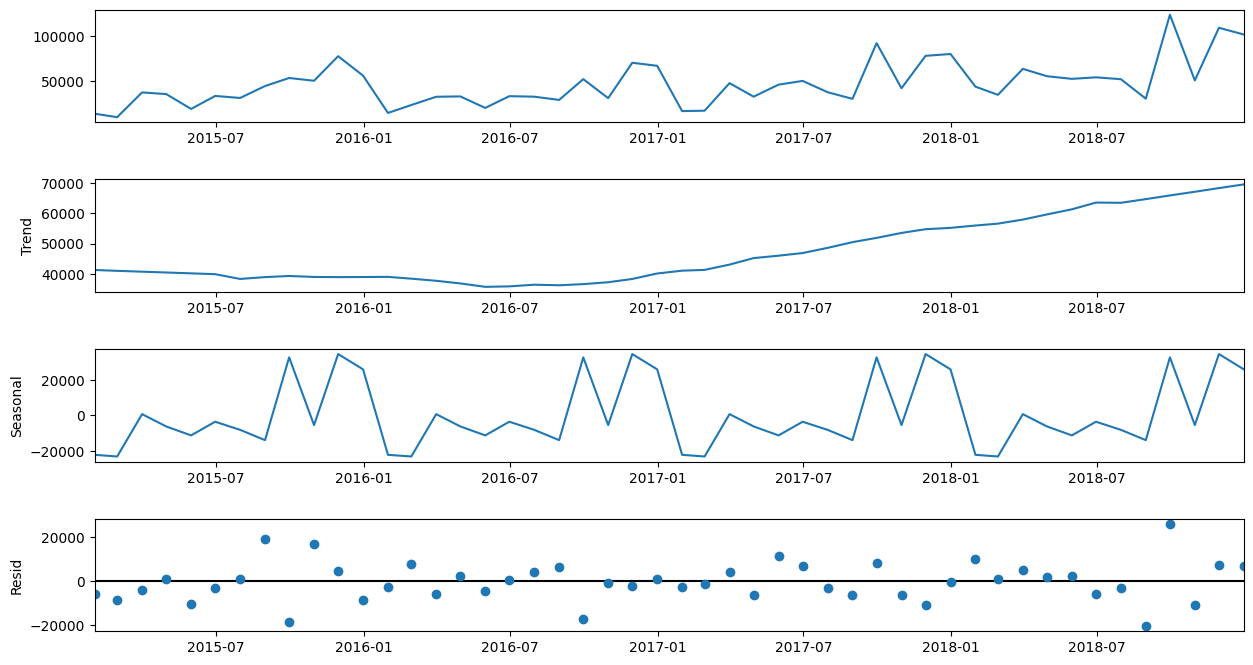

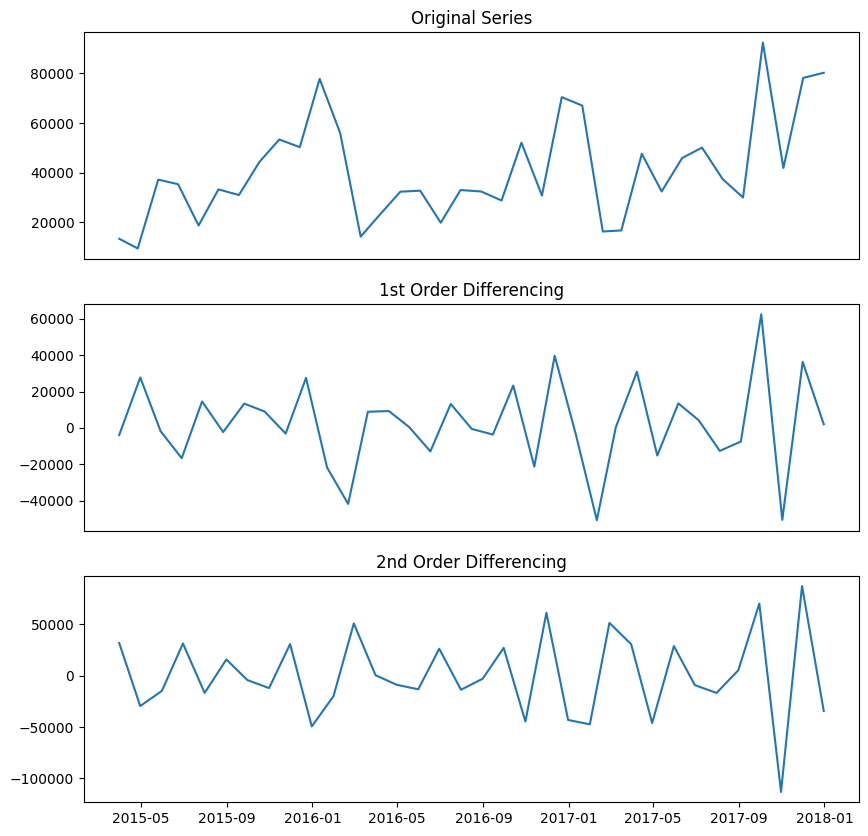

Mean Absolute Error = 19710.693471525752
Root Mean Squared Error = 23415.79576707235
r2 score = 0.3574219691517977
Mean absolute percentage error = 0.3006459246173478
_______________________________________________________________________
Eggs, Meat & Fish 

Results of Dickey-Fuller Test:
Test Statistic                 -3.860622
p-value                         0.002345
Lags Used                       0.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


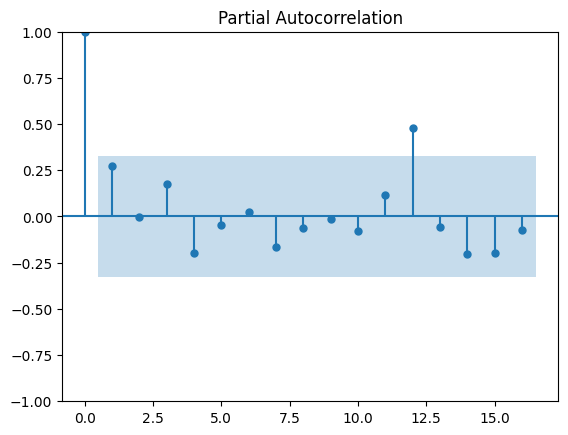

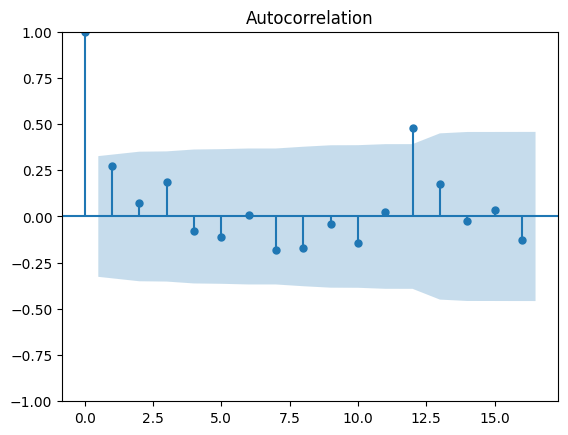

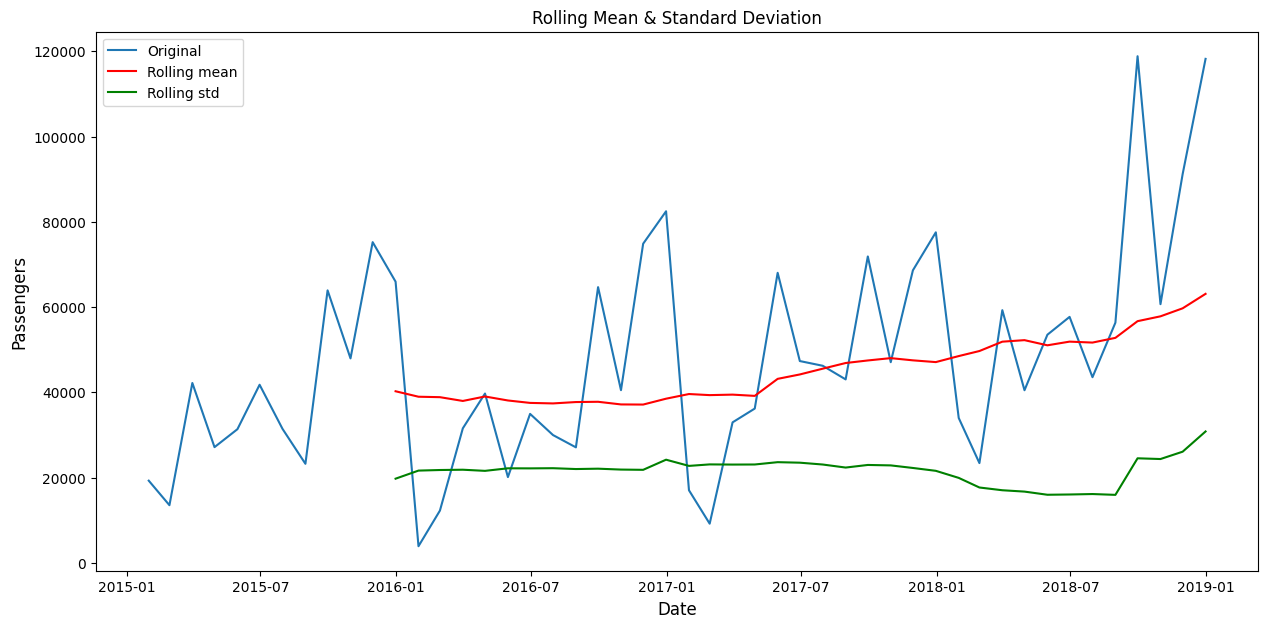

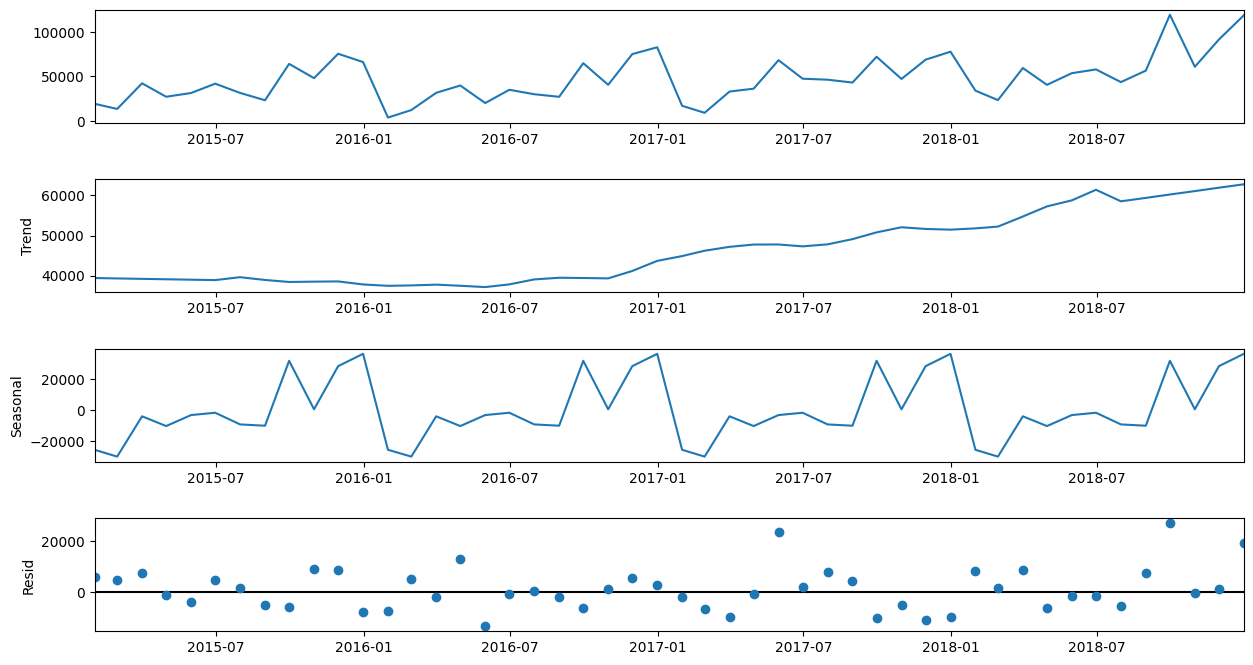

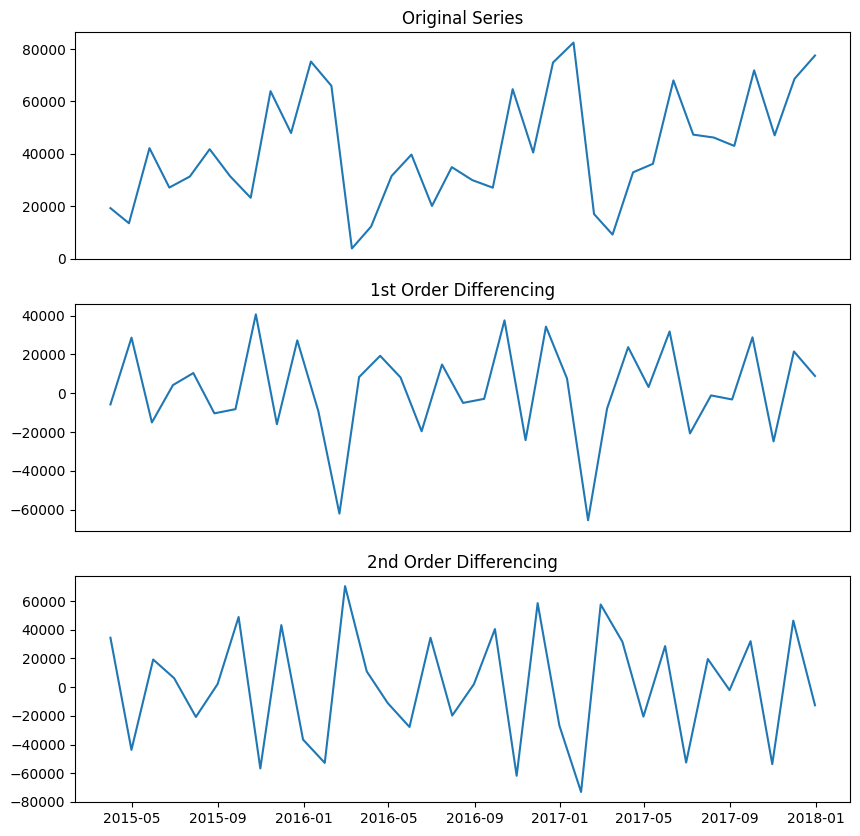

Mean Absolute Error = 20434.43713149131
Root Mean Squared Error = 27120.49395937269
r2 score = 0.15506487606890618
Mean absolute percentage error = 0.28690409459241334


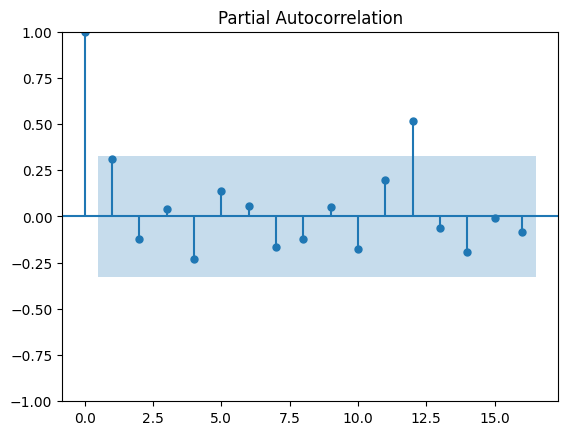

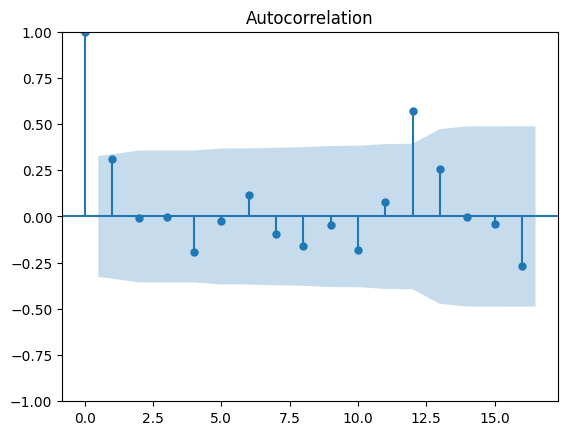

In [10]:
for i in cat:
  fun(i)

In [12]:
tb = pd.DataFrame(table1, index=['Mean absolute error', 'Root Mean square error', 'r2 score', 'Mean absolute percentage error'])
# # print(tb)
# # print('_____________________________________________________________________')
# # print('\n\n')
# s = '/content/res.xlsx'
# # print(s)
# tb.to_excel(s)

In [13]:
print(tb)

                                Oil & Masala     Beverages   Food Grains  \
Mean absolute error             17009.121287  18423.786207  18727.270960   
Root Mean square error          21242.501162  21081.351704  22628.115757   
r2 score                           -0.049192      0.327168      0.296608   
Mean absolute percentage error      0.400256      0.307394      0.381825   

                                Fruits & Veggies        Bakery        Snacks  \
Mean absolute error                 18923.483735  16092.301001  19710.693472   
Root Mean square error              24471.261654  18839.276026  23415.795767   
r2 score                                0.048740      0.418758      0.357422   
Mean absolute percentage error          0.276122      0.272012      0.300646   

                                Eggs, Meat & Fish  
Mean absolute error                  20434.437131  
Root Mean square error               27120.493959  
r2 score                                 0.155065  
Mean absol